In [1]:
# ! pip install gdown
# ! pip install zipfile
# ! pip install matplotlib
# ! pip install ultralyctics
# ! pip install cv2
# ! pip install ultralytics

import gdown
import zipfile
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
import os
import cv2  # image resizing

In [2]:
import os
import shutil

def remove_dataset_folder(folder_name):
    folder_path = os.path.join('dataset', folder_name)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        print(f"Removing old folder: {folder_path}")
        shutil.rmtree(folder_path)
    else:
        print(f"No existing folder to remove at: {folder_path}")

# Example usage: delete "rice_leaf" folder inside ./datasets
remove_dataset_folder('./1')

No existing folder to remove at: dataset\./1


In [3]:
import kagglehub

path = kagglehub.dataset_download("warcoder/nutrient-deficient-banana-plant-leaves")

print("Path to dataset files:", path)
# C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1

c:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 36%|███▌      | 57.0M/157M [00:05<00:10, 10.1MB/s]


KeyboardInterrupt: 

In [6]:
# Define paths
src_folder = os.path.expanduser(path)
dst_folder = "./dataset"

shutil.move(src_folder, dst_folder)

'./dataset'

In [7]:
# PROCESSING IMAGES
  # resizing: for uniform image sizes (set to 640x640)
  # augmentation: for balancing of training dataset

import cv2
import os
import numpy as np
import albumentations as A
import random
import tensorflow as tf

dataset_path = "./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves"

# Target image size
TARGET_SIZE = (640, 640)

# Maximum images per class
MAX_IMAGES_PER_CLASS = 1000

# Sequential augmentation functions 
transform = A.Compose([
    A.Rotate(limit=20), # Randomly rotates the image between -20 and +20 degrees
    A.HorizontalFlip(p=0.5), # probability of it happening (0.5: 50% chance of applying)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Function to resize (224) and augment images 
def process_images(path):
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)

        # Get list of images
        img_files = os.listdir(class_path)
        original_count = len(img_files)

        # Resize and convert images
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Couldn't read {img_path}")
                continue

            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(img_path, img_resized)

        # Calculate how many more images are needed
        needed_augmentations = max(0, MAX_IMAGES_PER_CLASS - original_count)

        # Generate only the required number of augmented images
        for i in range(needed_augmentations):
            img_name = random.choice(img_files)  # Pick a random image
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # transform image to make augmented images
            # ['image'] used because transform returns dictionary and we only want the image
            augmented = transform(image=img)['image']
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(class_path, aug_img_name), augmented)

        print(f"{class_folder} processing complete now with {min(MAX_IMAGES_PER_CLASS, original_count + needed_augmentations)} images")


# process function call
process_images(dataset_path)

boron processing complete now with 1000 images
calcium processing complete now with 1000 images
healthy processing complete now with 1000 images
iron processing complete now with 1000 images
magnesium processing complete now with 1000 images
manganese processing complete now with 1000 images
potassium processing complete now with 1000 images
sulphur processing complete now with 1000 images
zinc processing complete now with 1000 images


In [9]:
import random
from pathlib import Path

# Settings
source_dir = Path('./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves')
target_dir = Path('./dataset/Banana_Leaves_Dataset')
split_ratios = {'train': 0.7, 'test': 0.2, 'val': 0.1}  # Adjust as needed
classes = [d.name for d in source_dir.iterdir() if d.is_dir()]

# Create the new directory structure
for split in split_ratios:
    for cls in classes:
        (target_dir / split / cls).mkdir(parents=True, exist_ok=True)

# Process each class
for cls in classes:
    images = list((source_dir / cls).glob('*'))
    random.shuffle(images)
    
    train_end = int(split_ratios['train'] * len(images))
    test_end = train_end + int(split_ratios['test'] * len(images))

    splits = {
        'train': images[:train_end],
        'test': images[train_end:test_end],
        'val': images[test_end:]
    }

    for split, files in splits.items():
        for file in files:
            shutil.copy(file, target_dir / split / cls / file.name)  # use shutil.move if you want to move instead of copy

print("Dataset has been split and organized.")

Dataset has been split and organized.


In [10]:
base_model = YOLO("yolo11n-cls.pt")

100%|██████████| 5.52M/5.52M [00:54<00:00, 107kB/s] 


In [11]:
print(base_model.info)

<bound method Model.info of YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [12]:
base_model.train(data="dataset/Banana_Leaves_Dataset", epochs=10, imgsz=640, freeze=10)

Ultralytics 8.3.126  Python-3.10.0 torch-2.7.0+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/Banana_Leaves_Dataset, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

train: Scanning C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\train... 6300 images, 0 corrupt: 100%|██████████| 6300/6300 [00:07<00:00, 811.94it/s]


train: New cache created: C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\train.cache
val: Fast image access  (ping: 0.20.0 ms, read: 4.00.7 MB/s, size: 31.1 KB)


c:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\val... 900 images, 0 corrupt: 100%|██████████| 900/900 [00:01<00:00, 813.81it/s]


val: New cache created: C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


c:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\classify\train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


c:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:47<00:00,  1.62s/it]

                   all      0.516      0.966

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:44<00:00,  1.52s/it]

                   all      0.639      0.979



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:45<00:00,  1.57s/it]

                   all      0.684      0.991

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:48<00:00,  1.68s/it]

                   all      0.729      0.992

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:48<00:00,  1.67s/it]


                   all      0.697      0.991

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:49<00:00,  1.69s/it]

                   all      0.747      0.996

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:51<00:00,  1.77s/it]

                   all      0.767      0.996

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:49<00:00,  1.72s/it]

                   all      0.741      0.994

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:47<00:00,  1.65s/it]

                   all      0.766      0.996

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G     0.7463         12        640: 100%|██████████| 394/394 [07:15<00:00,  1.11s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:48<00:00,  1.66s/it]

                   all       0.77      0.996

10 epochs completed in 1.352 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.2MB


Optimizer stripped from runs\classify\train\weights\best.pt, 3.2MB

Validating runs\classify\train\weights\best.pt...
Ultralytics 8.3.126  Python-3.10.0 torch-2.7.0+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
YOLO11n-cls summary (fused): 47 layers, 1,537,553 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\train... found 6300 images in 9 classes  
val: C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\val... found 900 images in 9 classes  
test: C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-train\dataset\Banana_Leaves_Dataset\test... found 1800 images in 9 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


                   all       0.77      0.996
Speed: 0.0ms preprocess, 33.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001437B742170>
curves: []
curves_results: []
fitness: 0.8827777802944183
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7699999809265137, 'metrics/accuracy_top5': 0.995555579662323, 'fitness': 0.8827777802944183}
save_dir: WindowsPath('runs/classify/train')
speed: {'preprocess': 0.0007013332409163316, 'inference': 33.80358711121112, 'loss': 6.722211967118912e-05, 'postprocess': 0.00018633332931333117}
task: 'classify'
top1: 0.7699999809265137
top5: 0.995555579662323

In [13]:
print(base_model.info)

<bound method Model.info of YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [2]:
# CHANGE THE FILE PATH BELOW
from ultralytics import YOLO
from pathlib import Path

base_path = Path.cwd() / "dataset/Banana_Leaves_Dataset"

data_yaml = f"""
train: {base_path / "test"}
val: {base_path / "val"}

nc: 9
names: ['boron', 'calcium', 'healthy', 'iron', 'magnesium', 'manganese', 'potassium', 'sulphur', 'zinc']
"""

with open("dataset/Banana_Leaves_Dataset/data.yaml", "w") as file:
    file.write(data_yaml)

In [4]:
model = YOLO("yolo_banana_nutrient_best.pt")
metrics = model.val(data='dataset/Banana_Leaves_Dataset/data.yaml')    
print(metrics)

Ultralytics 8.3.126  Python-3.10.0 torch-2.7.0+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
YOLO11n-cls summary (fused): 47 layers, 1,537,553 parameters, 0 gradients, 3.2 GFLOPs
val: Fast image access  (ping: 0.30.1 ms, read: 54.77.3 MB/s, size: 31.1 KB)


val: Scanning C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-banana-train\dataset\Banana_Leaves_Dataset\val... 900 images, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 4261.75it/s]

val: New cache created: C:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-banana-train\dataset\Banana_Leaves_Dataset\val.cache



c:\Users\jpark\OneDrive\Documents\Codes\python\Nutrient-Deficiency-Model-API\yolo-banana-train\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
               classes   top1_acc   top5_acc: 100%|██████████| 57/57 [00:32<00:00,  1.74it/s]


                   all       0.77      0.996
Speed: 0.0ms preprocess, 28.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001944E00C3A0>
curves: []
curves_results: []
fitness: 0.8827777802944183
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7699999809265137, 'metrics/accuracy_top5': 0.995555579662323, 'fitness': 0.8827777802944183}
save_dir: WindowsPath('runs/classify/val')
speed: {'preprocess': 0.001327222044993606, 'inference': 28.466899555642158, 'loss': 0.00010100002529927426, 'postprocess': 0.00018733330459023514}
task: 'classify'
top1: 0.7699999809265137
top5: 0.995555579662323


In [40]:
import shutil

shutil.copyfile("runs/classify/train/weights/best.pt", "yolo_banana_nutrient_best.pt")

'yolo_banana_nutrient_best.pt'


0: 640x640 boron 1.00, calcium 0.00, potassium 0.00, healthy 0.00, sulphur 0.00, 39.0ms
1: 640x640 calcium 0.53, magnesium 0.15, zinc 0.13, sulphur 0.12, healthy 0.04, 39.0ms
2: 640x640 healthy 0.63, calcium 0.19, sulphur 0.12, iron 0.03, zinc 0.01, 39.0ms
3: 640x640 iron 0.90, zinc 0.08, sulphur 0.01, magnesium 0.01, manganese 0.01, 39.0ms
4: 640x640 magnesium 0.89, calcium 0.06, sulphur 0.03, zinc 0.01, manganese 0.01, 39.0ms
5: 640x640 manganese 0.91, iron 0.03, calcium 0.02, sulphur 0.02, magnesium 0.01, 39.0ms
6: 640x640 potassium 1.00, magnesium 0.00, sulphur 0.00, boron 0.00, calcium 0.00, 39.0ms
7: 640x640 sulphur 0.67, zinc 0.11, calcium 0.11, healthy 0.07, manganese 0.02, 39.0ms
8: 640x640 zinc 0.49, sulphur 0.31, healthy 0.06, calcium 0.05, potassium 0.03, 39.0ms
Speed: 9.2ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


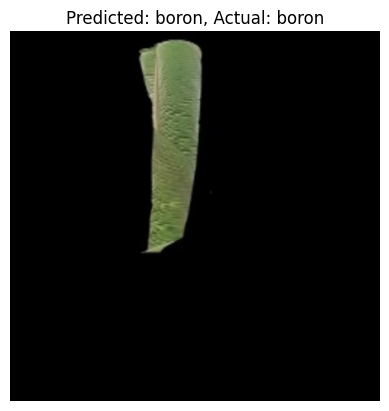

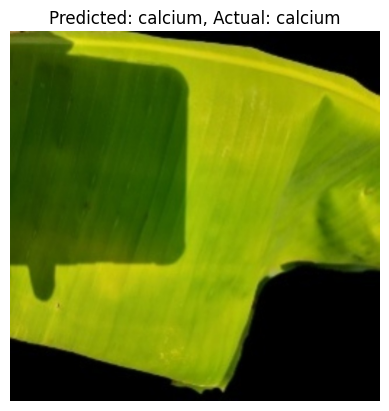

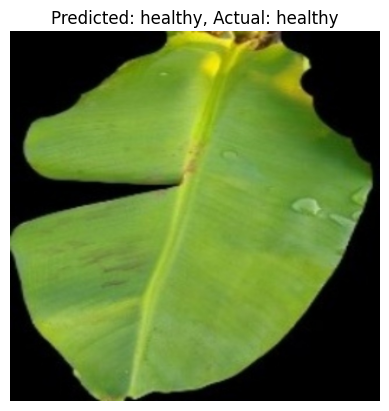

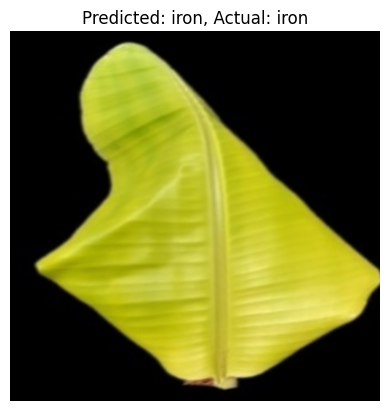

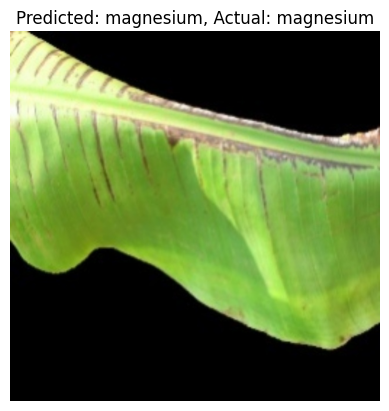

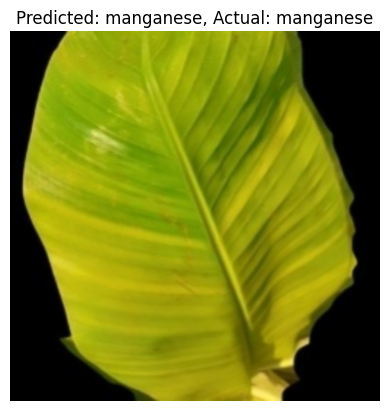

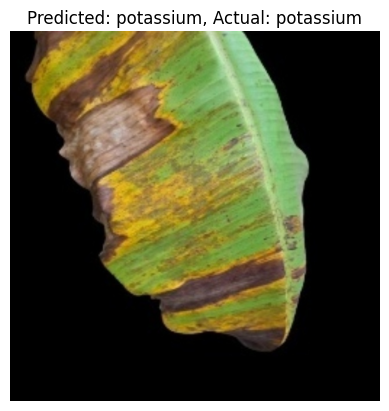

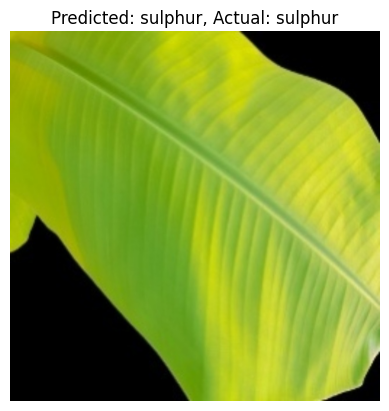

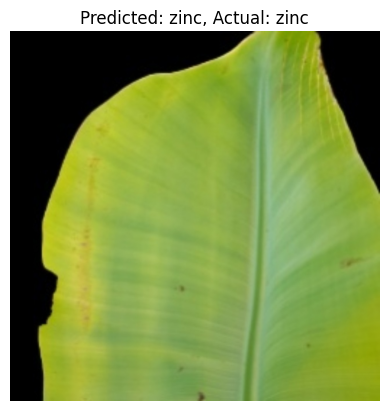

In [ ]:
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO
%matplotlib inline

model = YOLO('yolo_banana_nutrient_best.pt')

base_path = Path("dataset/Banana_Leaves_Dataset/test").resolve()

class_names = ['boron', 'calcium', 'healthy', 'iron', 'magnesium', 'manganese', 'potassium', 'sulphur', 'zinc']

images = []
image_labels = []

# Loop through each class and select a random image
for class_name in class_names:
    class_dir = base_path / class_name
    if not class_dir.exists():
        print(f"Warning: Folder not found for class '{class_name}' → {class_dir}")
        continue

    image_files = list(class_dir.glob("*.jpg"))
    if not image_files:
        print(f"Warning: No .jpg images found in {class_dir}")
        continue

    random_image_path = random.choice(image_files)
    images.append(str(random_image_path))
    image_labels.append(class_name)

results = model(images)

# Display each prediction
for i in range(len(images)):
    plt.imshow(plt.imread(images[i]))
    plt.title(f"Predicted: {class_names[results[i].probs.top1]}, Actual: {image_labels[i]}")
    plt.axis("off")
    plt.show()

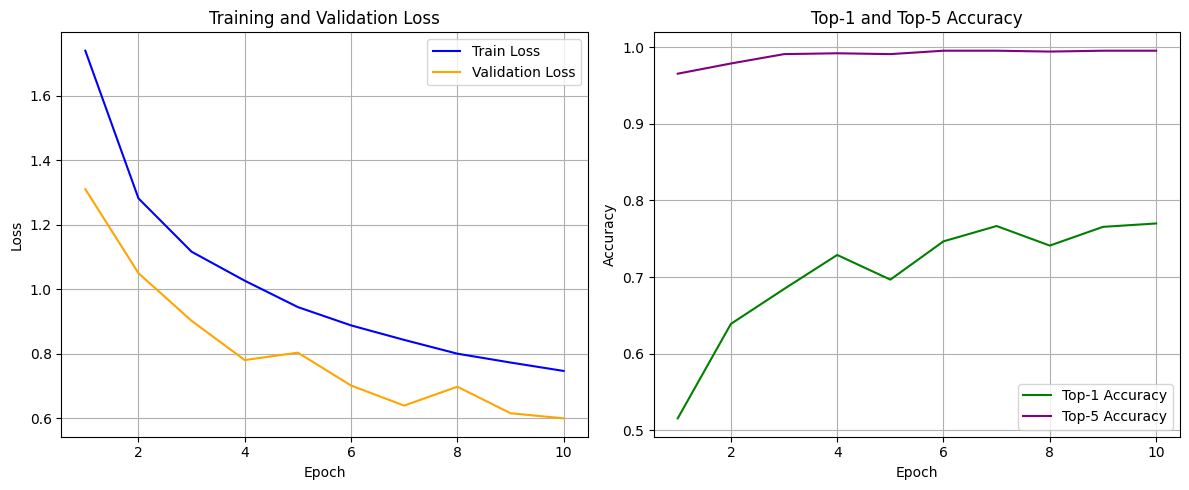

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv file
results_path = "runs/classify/train/results.csv"

# Extract data
epochs = df["epoch"]
train_loss = df["train/loss"]
val_loss = df["val/loss"]
acc_top1 = df["metrics/accuracy_top1"]
acc_top5 = df["metrics/accuracy_top5"]

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="orange")
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_top1, label="Top-1 Accuracy", color="green")
plt.plot(epochs, acc_top5, label="Top-5 Accuracy", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-5 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()